In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer
import networkx as nx
import scipy.sparse as sp

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from util.evaluation_metrics import trustworthiness, nearest_neighbours_generalisation_accuracy

In [3]:
from core.SimpleNet import SimpleNet
from core.OldGraphConvNet2 import OldGraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from core.EmbeddingDataSet import EmbeddingDataSet
from util.plot_graph_embedding import plot_graph_embedding
from util.evaluation_metrics import evaluate_net_metrics, evaluate_embedding_metrics, graph_trustworthiness

In [4]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [5]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'cuda'
else:
    print('cuda not available')
    device = 'cpu'

cuda not available


In [6]:
dataset_name = 'cora'
parent_dir = os.path.abspath('..')
input_dir = os.path.join(parent_dir, 'data')
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(split_batches=False, shuffle=True)
dataset.summarise()

Name of dataset = cora
Input dimension = 1433
Number of training samples = None
Training labels = True
Graph information = True


In [7]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = dataset.input_dim # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers

In [8]:
# Graph net
net_1 = OldGraphConvNet2(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/cora_2/'
filename = root + 'graph_net_800.pkl'
checkpoint = torch.load(filename, map_location=device)
net_1.load_state_dict(checkpoint['state_dict'])
net_1.eval()

OldGraphConvNet2(
  (gnn_cells): ModuleList(
    (0): OldGraphConvNetCell(
      (Ui1): Linear(in_features=1433, out_features=50, bias=False)
      (Uj1): Linear(in_features=1433, out_features=50, bias=False)
      (Vi1): Linear(in_features=1433, out_features=50, bias=False)
      (Vj1): Linear(in_features=1433, out_features=50, bias=False)
      (Ui2): Linear(in_features=50, out_features=50, bias=False)
      (Uj2): Linear(in_features=50, out_features=50, bias=False)
      (Vi2): Linear(in_features=50, out_features=50, bias=False)
      (Vj2): Linear(in_features=50, out_features=50, bias=False)
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=1433, out_features=50, bias=False)
    )
    (1): OldGraphConvNetCell(
      (Ui1): Linear(in_features=50, out_features=50, bias=False)
      (Uj1): Linear(in_features=50, out_featu

In [9]:
# Simple net
net_2 = SimpleNet(net_parameters)
if torch.cuda.is_available(): net_2.cuda()
root = 'results/cora_3/'
filename = root + 'simple_net_3000.pkl'
checkpoint = torch.load(filename, map_location=device)
net_2.load_state_dict(checkpoint['state_dict'])
net_2.eval()

SimpleNet(
  (fc1): Linear(in_features=1433, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=2000, bias=True)
  (fc4): Linear(in_features=2000, out_features=2, bias=True)
)

In [10]:
# Graph net
net_parameters['L'] = 5
net_3 = OldGraphConvNet2(net_parameters)
if torch.cuda.is_available(): net_3.cuda()
root = 'results/cora_5/'
filename = root + 'graph_net_1000.pkl'
checkpoint = torch.load(filename, map_location=device)
net_3.load_state_dict(checkpoint['state_dict'])
net_3.eval()

OldGraphConvNet2(
  (gnn_cells): ModuleList(
    (0): OldGraphConvNetCell(
      (Ui1): Linear(in_features=1433, out_features=50, bias=False)
      (Uj1): Linear(in_features=1433, out_features=50, bias=False)
      (Vi1): Linear(in_features=1433, out_features=50, bias=False)
      (Vj1): Linear(in_features=1433, out_features=50, bias=False)
      (Ui2): Linear(in_features=50, out_features=50, bias=False)
      (Uj2): Linear(in_features=50, out_features=50, bias=False)
      (Vi2): Linear(in_features=50, out_features=50, bias=False)
      (Vj2): Linear(in_features=50, out_features=50, bias=False)
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=1433, out_features=50, bias=False)
    )
    (1): OldGraphConvNetCell(
      (Ui1): Linear(in_features=50, out_features=50, bias=False)
      (Uj1): Linear(in_features=50, out_featu

In [11]:
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(split_batches=False, shuffle=True)

In [12]:
# tSNE
D = pairwise_distances(dataset.inputs, metric='cosine')
beta = 0.7
affinity_matrix = beta * dataset.adj_matrix * D
D = D - affinity_matrix

embedder = TSNE(n_components=2, metric='precomputed', method="exact", perplexity=30, verbose=1)
y_pred_tsne = embedder.fit_transform(D)

[t-SNE] Computed conditional probabilities for sample 1000 / 2485
[t-SNE] Computed conditional probabilities for sample 2000 / 2485
[t-SNE] Computed conditional probabilities for sample 2485 / 2485
[t-SNE] Mean sigma: 0.288236
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.219419
[t-SNE] KL divergence after 1000 iterations: 1.504092


In [13]:
# Spectral
from sklearn.manifold import SpectralEmbedding
affinity_matrix = 1 - D 
embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
y_pred_spectral = embedding.fit_transform(affinity_matrix)

In [14]:
time_start = timer()

if torch.cuda.is_available():   
    y_pred_1 = net_1.forward(dataset.all_data[0]).cpu().detach().numpy()
else:   
    y_pred_1 = net_1.forward(dataset.all_data[0]).detach().numpy()
    
time_elapsed = timer() - time_start

y_pred_1.shape

(2485, 2)

In [15]:
time_start = timer()

if torch.cuda.is_available():   
    y_pred_2 = net_2.forward(dataset.all_data[0]).cpu().detach().numpy()
else:   
    y_pred_2 = net_2.forward(dataset.all_data[0]).detach().numpy()
    
time_elapsed = timer() - time_start

y_pred_2.shape

(2485, 2)

In [16]:
time_start = timer()

if torch.cuda.is_available():   
    y_pred_3 = net_3.forward(dataset.all_data[0]).cpu().detach().numpy()
else:   
    y_pred_3 = net_3.forward(dataset.all_data[0]).detach().numpy()
    
time_elapsed = timer() - time_start

y_pred_3.shape

(2485, 2)

In [17]:
labels = np.array([int(l) for l in dataset.labels])
adj = sp.coo_matrix(dataset.adj_matrix)

In [18]:
plot_graph_embedding(y_pred_tsne, labels, adj)

In [19]:
plot_graph_embedding(y_pred_spectral, labels, adj)

In [20]:
plot_graph_embedding(y_pred_1, labels, adj)

In [21]:
plot_graph_embedding(y_pred_2, labels, adj)

In [22]:
plot_graph_embedding(y_pred_3, labels, adj)

In [23]:
G = nx.from_numpy_matrix(adj.toarray())
path_lengths = dict(nx.all_pairs_shortest_path_length(G))

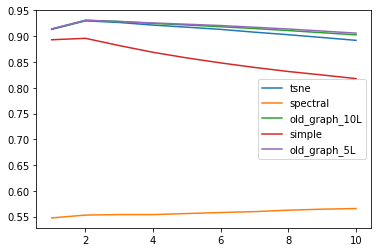

In [24]:
test_range = list(range(1, 11))
y_tsne = np.zeros(len(test_range))
y_spectral = np.zeros(len(test_range))
y_1 = np.zeros(len(test_range))
y_2 = np.zeros(len(test_range))
y_3 = np.zeros(len(test_range))

for i, k in enumerate(test_range):
    y_tsne[i] = graph_trustworthiness(path_lengths, y_pred_tsne, n_neighbors=k)
    y_spectral[i] = graph_trustworthiness(path_lengths, y_pred_spectral, n_neighbors=k)
    y_1[i] = graph_trustworthiness(path_lengths, y_pred_1, n_neighbors=k)
    y_2[i] = graph_trustworthiness(path_lengths, y_pred_2, n_neighbors=k)
    y_3[i] = graph_trustworthiness(path_lengths, y_pred_3, n_neighbors=k)

plt.plot(test_range, y_tsne, label='tsne')
plt.plot(test_range, y_spectral, label='spectral')
plt.plot(test_range, y_1, label='old_graph_10L')
plt.plot(test_range, y_2, label='simple')
plt.plot(test_range, y_3, label='old_graph_5L')
plt.legend()

In [25]:
def get_net_projection(all_data, net):
    all_y_pred = []
    net.eval()

    for G in all_data:
        if torch.cuda.is_available():
            y_pred = net.forward(G).cpu().detach().numpy()
        else:
            y_pred = net.forward(G).detach().numpy()
        all_y_pred.append(y_pred)

    return np.concatenate(all_y_pred, axis=0)

In [26]:
# Graph net
net_parameters['L'] = 10
net_4 = OldGraphConvNet2(net_parameters)
if torch.cuda.is_available(): net_1.cuda()
root = 'results/cora_6/'
filename = root + 'graph_net_800.pkl'
checkpoint = torch.load(filename, map_location=device)
net_4.load_state_dict(checkpoint['state_dict'])
net_4.eval()

OldGraphConvNet2(
  (gnn_cells): ModuleList(
    (0): OldGraphConvNetCell(
      (Ui1): Linear(in_features=1433, out_features=50, bias=False)
      (Uj1): Linear(in_features=1433, out_features=50, bias=False)
      (Vi1): Linear(in_features=1433, out_features=50, bias=False)
      (Vj1): Linear(in_features=1433, out_features=50, bias=False)
      (Ui2): Linear(in_features=50, out_features=50, bias=False)
      (Uj2): Linear(in_features=50, out_features=50, bias=False)
      (Vi2): Linear(in_features=50, out_features=50, bias=False)
      (Vj2): Linear(in_features=50, out_features=50, bias=False)
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (R): Linear(in_features=1433, out_features=50, bias=False)
    )
    (1): OldGraphConvNetCell(
      (Ui1): Linear(in_features=50, out_features=50, bias=False)
      (Uj1): Linear(in_features=50, out_featu

In [79]:
dataset = EmbeddingDataSet(dataset_name, input_dir, train=True)
dataset.create_all_data(split_batches=True, shuffle=True)
y_pred_4 = get_net_projection(dataset.all_data, net_4)
y_pred_4 = y_pred_4[np.argsort(dataset.all_indices)]
plot_graph_embedding(y_pred_4, labels, adj)

In [80]:
def get_k_equal_chunks(n, k):
    # returns n % k sub-arrays of size n//k + 1 and the rest of size n//k
    p, r = divmod(n, k)
    return [p + 1 for _ in range(r)] + [p for _ in range(k - r)]

In [83]:
get_k_equal_chunks(2708, k=1)

[2708]